In [1]:
# в режиме отладки будем править файлы
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob, os, json
from pathlib import Path
from tqdm import tqdm
import re
from pycocotools.coco import COCO                                           # проверка JSON
from datasetconverter import *                                              # импортируем  конвертор   VOC XML  в COCO JSON
from metrics_calc import *                                                  # импортируем  функции для расчета метрик
from video_processing import *                                              # импортируем  функции для обработки видео файлов
from pdf_reports import * 
from prepost import verify_and_visualize, class_distribution, draw_fcos_img, convert_voc_folder, measure_fps         # визуализация изображения и проверка датасета
import mmdet                                                                # импортируем  mmdet
import random                                                               # для случайного изображения из выборки
from ultralytics import YOLO                                                # для Yolo model
from mmdet.apis import init_detector, inference_detector
import mmcv
from mmengine.visualization import Visualizer
from mmdet.registry import VISUALIZERS
import cv2
from mmengine.runner import Runner                                           # для запуска обучения
from mmengine import Config                                                  # для подгрузки файла конфигуратора
from mmdet.apis import DetInferencer                                         # дли интерференции модели FCOS
# контроль и анализ
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
# для работы с изображениями
from PIL import ImageOps, Image
# для загрузки и предобработки изображений
# для работы с datasets и моделями
from functools import partial
import torch
from torch.utils.data import Dataset, DataLoader


In [3]:
import warnings
warnings.filterwarnings("ignore")

# **Проект: Детекция персонажей Minecraft с FCOS и YOLO**


## **Цель проекта**
Обучить и сравнить две модели детекции объектов — **FCOS (MMDetection)** и **YOLOv8 (Ultralytics)** — на кастомном датасете из игры **Minecraft**, содержащем 17 классов мобов.  
Задача моделей — находить на изображениях различных персонажей Minecraft и классифицировать их по типам.

---

## **Описание задачи**
Нужно:
- подготовить датасет в формате COCO;
- настроить и обучить FCOS в MMDetection;
- настроить и обучить YOLOv8;
- выполнить инференс обеих моделей на изображениях и видео;
- собрать метрики (mAP, mAP@50, Precision, Recall, F1, FPS);
- сравнить результаты и подготовить отчёт.

---

## **Описание данных**

Датасет содержит изображения игрового мира Minecraft с объектами следующих классов:

```
['bee', 'chicken', 'cow', 'creeper', 'enderman', 'fox', 'frog',
 'ghast', 'goat', 'llama', 'pig', 'sheep', 'skeleton', 'spider',
 'turtle', 'wolf', 'zombie']
```

Структура папок:

```
datasets/minecraft/
    ├── train/
    │     ├── *.jpg
    │     └── _annotations.coco.json
    ├── val/
    ├── test/
    └── video.mp4
```

Формат аннотаций — **COCO JSON**.

---

## **Этапы проекта**

### **1. Подготовка**
- установка MMDetection;
- загрузка датасета;
- создание структуры проекта;
- подготовка ноутбука.

---

### **2. EDA (исследовательский анализ данных)**
- проверка COCO-аннотаций;
- проверить, что количество изображений совпадает с количеством аннотаций;
- визуализация распределения классов;
- просмотр примеров изображений;
- проверка корректности bbox;
- планирование подходов к обучению и аугментациям.

---

### **3. Настройка моделей**

#### **FCOS (MMDetection)**
- создание конфига `fcos_minecraft.py`;
- настройка:
  - `_base_`,
  - метаинформации (классы),
  - путей к датасету,
  - train/test pipeline,
  - параметров обучения;
- тест инференса pretrained FCOS.

#### **YOLOv8**
- создание `data_coco.yaml`;
- проверка pretrained YOLO на изображении.

---

### **4. Обучение моделей**

#### **FCOS**
- запуск обучения через MMDetection;
- сохранение логов и лучших весов.

#### **YOLOv8**
- запуск обучения YOLO;
- сохранение `results.csv` и `best.pt`.

---

### **5. Инференс**

#### На изображениях:
- сохранить результаты в:
  - `artifacts/inference/fcos/`
  - `artifacts/inference/yolo/`

#### На видео:
- выполнить детекцию на `video.mp4`;
- сохранить:
  - `fcos_inference.mp4`
  - `yolo_inference.mp4`

---

### **6. Сравнение качества моделей**
Вычислить и сравнить:

- mAP  
- mAP@50  
- Precision  
- Recall  
- F1-score  
- FPS  

Сохранить итоговую таблицу в `artifacts/metrics/`.

---

### **7. Аналитика и отчёт**
Подготовить выводы:

- какая модель точнее;
- какая быстрее;
- примеры успешных и неудачных детекций;
- где модели ошибаются и почему.

Сформировать итоговый PDF-отчёт.


## Этап 0 — Специфика Minecraft
- [x] Ознакомиться с типами мобов (friendly / neutral / hostile) и как они выглядят визуально
- [x] Просмотреть список классов датасета (17 классов) и запомнить отличия (bee, chicken, cow, creeper, ... zombie)

# **1. Подготовка и анализ данных**

In [4]:
class_names=[
        'bee', 'chicken', 'cow', 'creeper', 'enderman', 'fox', 'frog', 'ghast',
        'goat', 'llama', 'pig', 'sheep', 'skeleton', 'spider', 'turtle', 'wolf', 'zombie'
    ]

In [5]:
folder = "dataset/minecraft/"
datasets = ['train', 'test', 'valid']

отрисуем по размеченному изображению из каждой выборки и проверим выборки на полноту

Данные для train выборки
Изображения без соответствующих меток:
  - Screenshot-188-_png.rf.7990d49953d8657dda9da38d1c75749a.jpg
  - 2023-04-03_19_17_30_png.rf.8ca8dad6210d53c762b3b8df9bbb5db2.jpg
Всего: 2 изображений

Итоговая статистика:
  Всего изображений: 2307
  Всего меток: 2305
  Полных пар: 2303
117_png_jpg.rf.94d44bac029971e08213da59da1db915.jpg


<Figure size 700x1200 with 0 Axes>

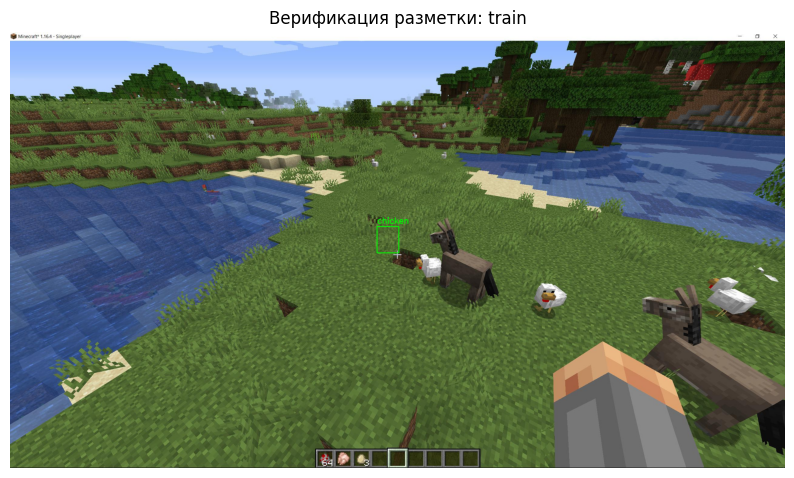

Данные для test выборки
Все файлы имеют соответствующие пары:
  Изображений: 155
  Меток: 155
-50-_jpg.rf.a37b955a20a12470f04f1d9d6070ca41.jpg


<Figure size 700x1200 with 0 Axes>

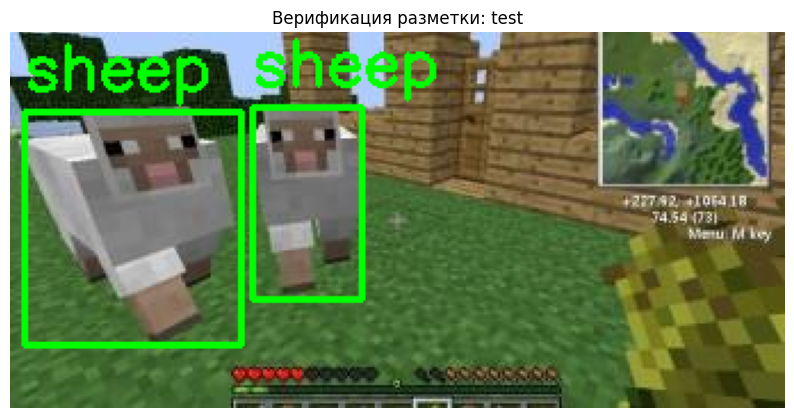

Данные для valid выборки
Все файлы имеют соответствующие пары:
  Изображений: 422
  Меток: 422
wolf21_jpg.rf.0725f28587c88d80f546cbf3bbdb4c29.jpg


<Figure size 700x1200 with 0 Axes>

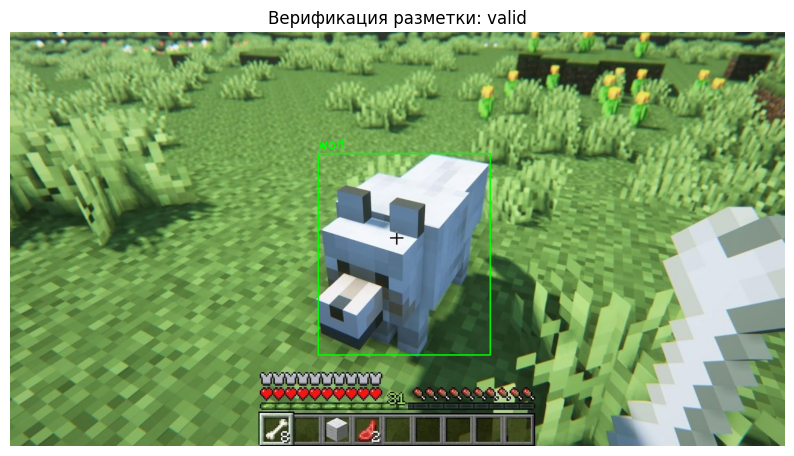

In [6]:
path_to_labels = "dataset/minecraft/labels.txt"
for dataset in datasets:
    print(f'Данные для {dataset} выборки')
    verify_and_visualize(path_to_labels, dataset) 

Не так плохо, всего два файла не имеют меток в тренировочной выборке. Ничего делать не будет, не большая потеря а размечать не хочется. Тестовая и валидационная небитые.

Изначально формат dataset VOC XML необходимо преобразовать в COCO JSON, используем функцию с сайта https://blog.roboflow.com/how-to-convert-annotations-from-voc-xml-to-coco-json/, а так же проверим формат файлов JSON 

Создадим файл JSON если его нет и положим в папку annotations. Проверим его содержимое

In [7]:

for dataset in datasets:
    path2jxmls = folder + dataset
    path2json  = folder + "annotations"
    json_files = glob.glob(path2json + "/*" + dataset + "*.json")
    if len(json_files)==0:
        xmls = glob.glob(path2jxmls+ "/*.xml")
        convert_xmls_to_cocojson(xmls, get_label2id("dataset/minecraft/labels.txt"), path2json + "/_" + dataset + "_annotations.coco.json")
    else: 
        print(f"в папке {dataset} уже есть файл JSON!")
    coco = COCO(path2json + "/_" + dataset + "_annotations.coco.json")
    print("COCO JSON загружен успешно!")

в папке train уже есть файл JSON!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
COCO JSON загружен успешно!
в папке test уже есть файл JSON!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
COCO JSON загружен успешно!
в папке valid уже есть файл JSON!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
COCO JSON загружен успешно!


Проверим для случайных изображений правильно ли собрались файлы JSON (потому, что был прецедент)

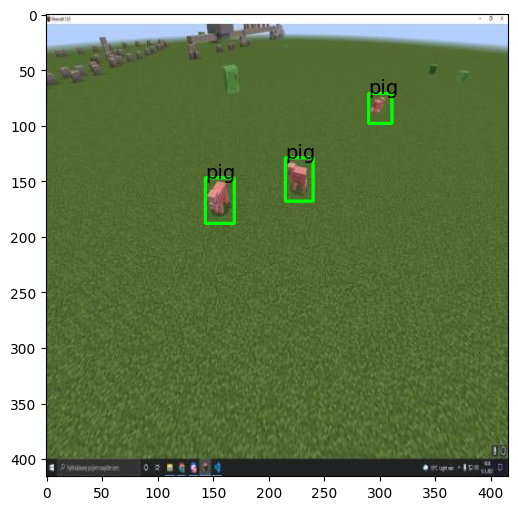

In [8]:
coco = json.load(open("dataset/minecraft/annotations/_test_annotations.coco.json", "r", encoding="utf-8"))
id2name = {c["id"]: c["name"] for c in coco["categories"]}

img = random.choice(coco["images"])
img_id = img["id"]
img_path = os.path.join("dataset/minecraft/test", os.path.basename(img["file_name"]))

anns = [a for a in coco["annotations"] if a["image_id"] == img_id]

img = cv2.imread(img_path)
plt.figure(figsize=(10, 6))
for a in anns:
    x, y, w, h = a["bbox"]  # COCO: xywh
    name = id2name[a["category_id"]]
    cv2.rectangle(img, (int(x), int(y)), (int(w+x), int(h+y)), (0, 255, 0), 2)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.text(x, y, name, fontsize=14)

plt.imshow(img_rgb)
plt.show()


JSON файлы созданы/проверены, можно продолжать

Будем обучать две модели, для одной FCOS структура файла соответствует требованиями, а для YOLO нужно создать файлы меток - то есть преобразовать формат из pascal voc xml -> yolo txt. 
Подредактикуем скрипт из статьи https://medium.com/internet-of-technology/convert-pascal-voc-to-yolo-format-b7672bcf0cb3

In [9]:
for dataset in datasets:
    convert_voc_folder(folder_path="dataset/minecraft/"+ dataset,
                       classes_file="dataset/minecraft/labels.txt"
)

[INFO] Загружено классов: 17
[INFO] Найдено изображений: 2307
[INFO] Найдено XML файлов в dataset\minecraft\train: 2305
[DONE] Конвертированы TXT → dataset\minecraft\train\labels
[DONE] Изображения скопированы → dataset\minecraft\train\images
[INFO] Загружено классов: 17
[INFO] Найдено изображений: 155
[INFO] Найдено XML файлов в dataset\minecraft\test: 155
[DONE] Конвертированы TXT → dataset\minecraft\test\labels
[DONE] Изображения скопированы → dataset\minecraft\test\images
[INFO] Загружено классов: 17
[INFO] Найдено изображений: 422
[INFO] Найдено XML файлов в dataset\minecraft\valid: 422
[DONE] Конвертированы TXT → dataset\minecraft\valid\labels
[DONE] Изображения скопированы → dataset\minecraft\valid\images


Проверим правильно ли создались файлы аннотаций в формате .txt для произвольного изображения выборки train

(399, 232) (451, 271)


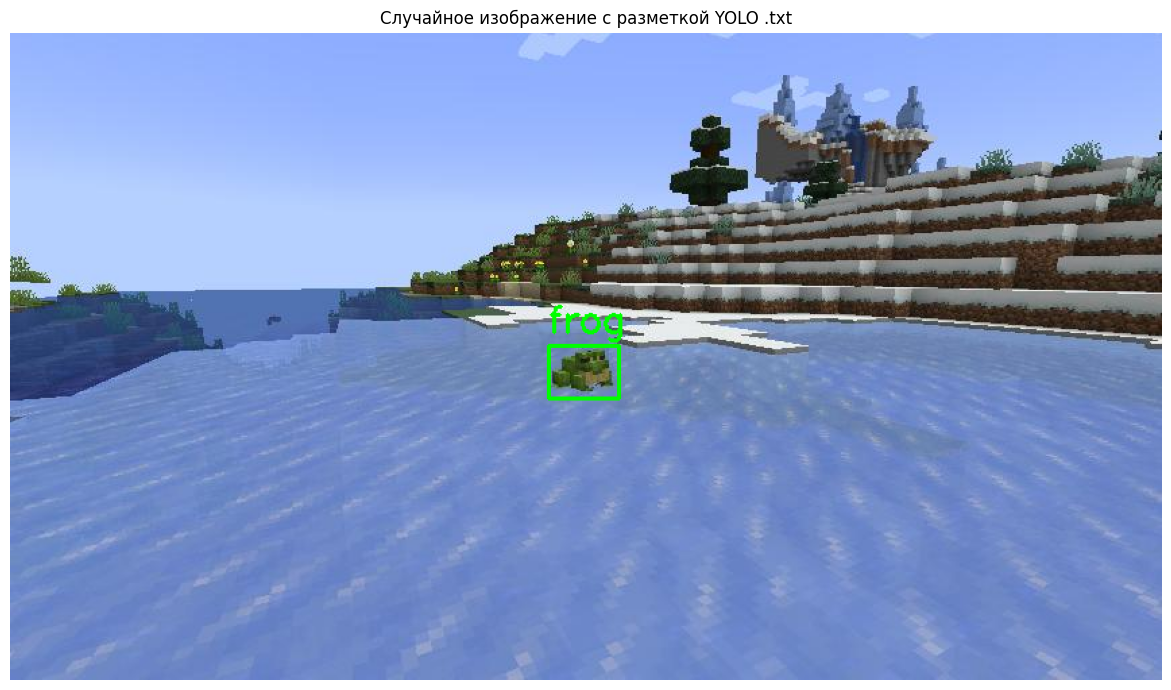

True

In [10]:

train_img = 'dataset/minecraft/train/'
all_images = [f for f in os.listdir(train_img) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image_name = random.choice(all_images)
check_path = os.path.join(train_img, random_image_name)
check_img = cv2.imread(check_path)
check_img = cv2.cvtColor(check_img, cv2.COLOR_BGR2RGB)

h, w  = check_img.shape[:2]
base = os.path.splitext(os.path.basename(check_path))[0]   # имя файла без расширения
label_path = os.path.join(train_img, 'labels', base + '.txt')

with open(label_path, "r") as f:
    lines = f.readlines()

# рисуем рамки
for line in lines:
    cls_id, x_c, y_c, bw, bh = map(float, line.split())
    cls_id = int(cls_id)

     # денормализация YOLO → пиксели
    x_c *= w
    y_c *= h
    bw *= w
    bh *= h
    # вычисляем xmin, ymin
    xmin = int(x_c - bw / 2)
    ymin = int(y_c - bh / 2)
    xmax = int(x_c + bw / 2)
    ymax = int(y_c + bh / 2)
    print((xmin, ymin), (xmax, ymax))

    cv2.rectangle(check_img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    text = f"{class_names[cls_id]}"
    cv2.putText(check_img, text, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2);

plt.figure(figsize=(14, 7))
plt.imshow(check_img)
plt.title("Случайное изображение с разметкой YOLO .txt")
plt.axis('off')
plt.tight_layout()
plt.show()

save_path = "artifacts/test_img.jpg"
cv2.imwrite(str(save_path), cv2.cvtColor(check_img, cv2.COLOR_RGB2BGR))


Вроде работает, продолжаем

Выполним оценку дисбаланса классов

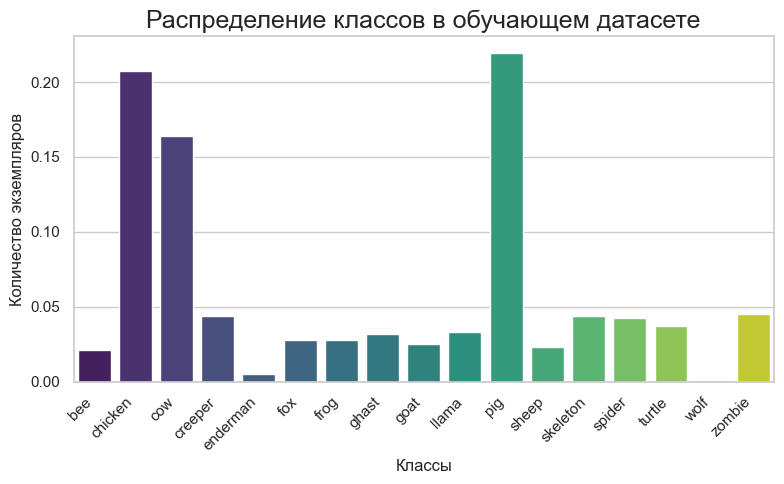

In [11]:
class_distribution(path_to_labels, 'train') 

Есть дисбаланс классов:
 - chicken, cow, pig встречаются значительно чаще, чем остальные
 - enderman и wolf очень редко

По идеи нужен Oversampling редких классов, потому что могут быть проблемы с их предсказыванием.......... и они будут )

**ВЫВОДЫ**

## Этап 1 — Подготовка и анализ данных (check-list)
### 1) Структура репозитория
- [x] Создан корень `mmdetection/`
- [x] Создана папка `mmdetection/datasets/`
- [x] Создан ноутбук `mmdetection/notebook.ipynb`
- [x] Создана папка `mmdetection/artifacts/`
- [x] Создана папка `mmdetection/artifacts/videos/`
- [x] Создана папка `mmdetection/artifacts/metrics/`
- [x] Создана папка `mmdetection/artifacts/inference/`
- [!] Создан файл `mmdetection/README.md` (кратко: цель, данные, модели, результаты) - хм пока не будем с этим торопиться

### 2) Данные
- [x] Датасет распакован в `datasets/minecraft/`
- [x] Структура соответствует:
  - [x] `datasets/minecraft/train/`
  - [x] `datasets/minecraft/val/`
  - [x] `datasets/minecraft/test/`
- [x] Файлы `_annotations.voc.json` перенесены в `datasets/minecraft/annotations/`
- [x] Видео для инференса сохранено как `datasets/minecraft/video.mp4`
#### 3) EDA и работа с данными
- [x] Проверить корректность JSON-аннотаций (`_annotations.voc.json`)
- [x] Проверить: количество изображений == количество аннотаций (train/val/test)
- [x] Посчитать распределение классов
- [x] Визуализировать распределение классов (график/барчарт)
- [x] Сделать вывод: есть ли дисбаланс классов
- [x] Визуализировать 1 тестовый пример с bbox + подписями классов
- [x] В Markdown-ячейке описать план проекта:
  - [x] как решается задача
  - [x] из чего состоит система (FCOS + YOLO, инференс на изображениях/видео, метрики, сравнение)

# **2. Настройка модели**

проверим правильно ли установлен MMDetection

In [12]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.1.0+cu118 True
3.3.0
11.8
MSVC 192930148


Перед обучением модель обязательно нужно проверить, что:
 - конфиг рабочий

- веса подгружаются

- изображения читаются

- пайплайн правильный

- нормализация корректная

Поэтомы выполним интерференс на случайном изображении для полностью предобученных моделях

## **2.1. Интерференс на FCOS**

In [13]:
# --- пути к конфигу и весам(используем стандартные) ---
config_path = 'configs/fcos/fcos_minecraft.py'
checkpoint_path = 'checkpoints/fcos_r50_caffe.pth'

In [14]:
# --- инициализация модели ---
model_fcos = init_detector(config_path, checkpoint_path, device='cuda:0') 

Loads checkpoint by local backend from path: checkpoints/fcos_r50_caffe.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.conv_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([17, 256, 3, 3]).
size mismatch for bbox_head.conv_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([17]).


Возьмем случайное изображение из test выборки

In [15]:
test_path = 'dataset/minecraft/test'
all_images = [f for f in os.listdir(test_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
random_image_name = random.choice(all_images)
test_img = os.path.join(test_path, random_image_name)
print(test_img)

dataset/minecraft/test\image19_png_jpg.rf.3dde04148d09d3833fb7fe06701b3efb.jpg


In [16]:
result_fcos = inference_detector(model_fcos, test_img)

In [17]:
# --- читаем изображение как numpy ---
img = cv2.imread(test_img)
# init visualizer (run the block only once in jupyter notebook)
visualizer = VISUALIZERS.build(model_fcos.cfg.visualizer)

# the dataset_meta is loaded from the checkpoint and then pass to the model in init_detector
visualizer.dataset_meta = model_fcos.dataset_meta
# --- фиксим палитру ---
num_classes = len(visualizer.dataset_meta["classes"])
visualizer.dataset_meta["palette"] = [(255, 0, 0)] * num_classes

# --- визуализатор модели ---
visualizer.add_datasample(
    name='result',
    image=img,
    data_sample=result_fcos,
    draw_gt=False,
    wait_time=0,
    out_file='artifacts/inference/pretrain/test_pretrained_fcos.jpg'
)

In [18]:
out_file = "artifacts/inference/pretrain/test_pretrained_fcos.jpg"

draw_fcos_img(
    model=model_fcos,
    result=result_fcos,
    img_path=test_img,
    out_path=out_file,
    score_thr = 0.4
)

[OK] Saved FCOS result to: artifacts/inference/pretrain/test_pretrained_fcos.jpg


'artifacts/inference/pretrain/test_pretrained_fcos.jpg'

## **2.2. Интерференс на YOLO**

Я не нашел в  MMDetection поддержки YOLOv5/YOLOv7/YOLOv8  и т.д., поэтому будем использовать ее отдельно, просто пути будет указывать исходя из имеющейся структуры проекта

In [19]:
model_yolo = YOLO('yolov8n.pt') 

In [20]:
# Формируем путь к сохранённому файлу
save_path = "artifacts/inference/pretrain/test_pretrained_yolo.jpg"
#out_file = "artifacts/inference/test_pretrained_yolo.jpg"
results = model_yolo.predict(
    source=test_img,
    project="artifacts/inference/pretrain",   # верхняя папка
    #name="test_pretrained_yolo.jpg",                 # подпапка
    save=False,
    conf=0.1
)

img = results[0].plot()          # numpy array (BGR для cv2)
cv2.imwrite(str(save_path), img)  # сохраняем ровно под нужным именем



image 1/1 g:\_Work\python_lab\practicum\advanced_part_Img_\Ch01_Objects_detection_\mmdetection\dataset\minecraft\test\image19_png_jpg.rf.3dde04148d09d3833fb7fe06701b3efb.jpg: 640x640 2 kites, 1 baseball glove, 8.4ms
Speed: 6.3ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


True

## **2.3. Отображение результатов**

Отобразим результат интерференса для обоих моделей

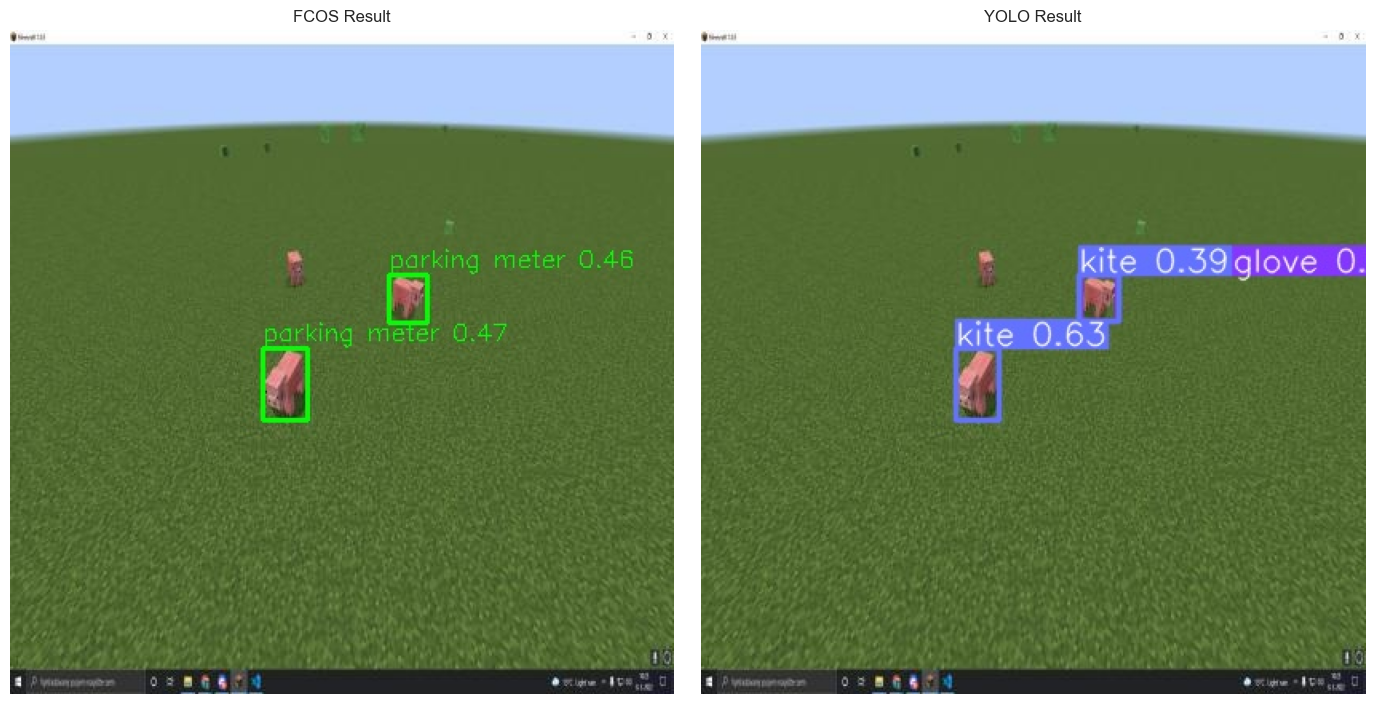

In [21]:
# --- Загружаем изображение c FCOS ---
fcos_img = Image.open("artifacts/inference/pretrain/test_pretrained_fcos.jpg")

# --- Загружаем изображение с YOLO ---
yolo_img = Image.open(save_path)

# --- Отображаем рядом ---
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(fcos_img)
plt.title("FCOS Result")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(yolo_img)
plt.title("YOLO Result")
plt.axis('off')

plt.tight_layout()
plt.show()

Предобученные модели FCOS и YOLO НЕ знает про коров, пчёл, криперов, зомби и т.д. Поэтому пытаются предсказать, что знают. Однако мы запустим инференс, потому что нужно проверить что:

✔ конфиг работает

✔ модель запускается

✔ пайплайн данных работает

✔ изображения читаются

✔ визуализация рисуется

✔ веса загружаются без ошибок

✔ код инференса не падает


................ и все вроде работает


## Этап 2 — Настройка модели (check-list)
### FCOS (MMDetection)
- [x] Создан конфиг `configs/fcos/fcos_minecraft.py`
- [x] Указан `_base_` (подключение базовых конфигов)
- [x] Настроен `model` (базовая модель FCOS)
- [x] Указаны классы обучения в `metainfo`
- [x] Определены `train_pipeline` и `test/val_pipeline` + аугментации
- [x] Настроены параметры обучения:
  - [x] `img_scale` уменьшен (например, `(512, 512)`)
  - [x] `checkpoint_interval = 1` (раз в эпоху)
  - [x] `max_epochs <= 72`
  - [x] `samples_per_gpu = 2`
  - [x] `workers_per_gpu = 2`
  - [x] `fp16 = dict(loss_scale='dynamic')`

### Предобученный FCOS — тест инференса
- [x] Скачан pretrained checkpoint `.pth` и положен в `checkpoints/`
- [x] В ноутбуке загружены: конфиг `fcos_minecraft.py` + pretrained `.pth`
- [x] Визуализирован инференс на 1 изображении
- [x] Сохранено: `artifacts/inference/test_pretrained_fcos.jpg`

### YOLO
- [x] Подготовлен файл датасета для YOLO: `datasets/minecraft/data_voc.yaml` (пути + классы)
- [x] Проверен инференс pretrained `YOLOv8s` на тестовом примере (я взял `YOLOv8n` я делаю все на ноутбуке дома)
- [x] Сохранено: `artifacts/inference/test_pretrained_yolo.jpg`

# **3. Обучение моделей**

In [22]:
# зададим тут сразу, чтоб не бегать по коду и не исправлять
max_epochs = 12

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **3.1. Дообучение модели семейства  YOLO**

Добавим аугментацию, например как было предложено в предыдущих заданиях

In [24]:
# Словарь аугментаций для разных уровней
augmentations =  {
    "hsv_h": 0.02,
    "hsv_s": 0.8,
    "hsv_v": 0.5,
    "fliplr": 0.5,
    "degrees": 15,
    "perspective": 0.001,
    "mixup": 0.1,
    "mosaic": 1.0,
}

Чтобы все попытки были не совсем лишние стартуем с лучших предыдущих весов. И чтобы постоянное не запускать код, сделаем проверку на наличие файла с лучшими весами, если он уже сформирован - пропустим этап обучения (если хочется не пропускать, можно не пропускать)

Хотя сделаем по другому, пускай обучается "с нуля" на 12 эпохах(для отчета и отображения хода обучения), а использовать будем при интерференции веса которые обучались на 72 эпохах.

In [25]:
if os.path.exists("checkpoints/last_best_yolo0.pt"):
    print('есть файл весов для модели, используем его: "checkpoints/last_best_yolo.pt" ')
    model_yolo = YOLO("checkpoints/last_best_yolo.pt")

else:
    print('нет файла весов стартуем с default values')
    model_yolo = YOLO('yolov8n.pt')
results = model_yolo.train(
                        data='dataset\minecraft\data_coco.yaml',
                        device=device,
                        epochs=max_epochs,                               
                        imgsz=512,
                        batch=16,
                        name='yolo_train',
                        project="artifacts/yolo",
                        patience=50,
                        **augmentations,
                        seed=42,                                          # Фиксируем seed для воспроизводимости
                        cos_lr=True,
                        save=True,
                        save_period=0, 
                        )
# загружаем лучшие веса вместо yolov8n.pt
print(f"используем файл весов для обученной модели: {results.save_dir}/weights/best.pt")
model_yolo = YOLO(f"{results.save_dir}/weights/best.pt")         

нет файла весов стартуем с default values


New https://pypi.org/project/ultralytics/8.3.250 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset\minecraft\data_coco.yaml, epochs=12, patience=50, batch=16, imgsz=512, save=True, save_period=0, cache=False, device=cuda, workers=8, project=artifacts/yolo, name=yolo_train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, form

используем файл весов для обученной модели: artifacts\yolo\yolo_train2/weights/best.pt


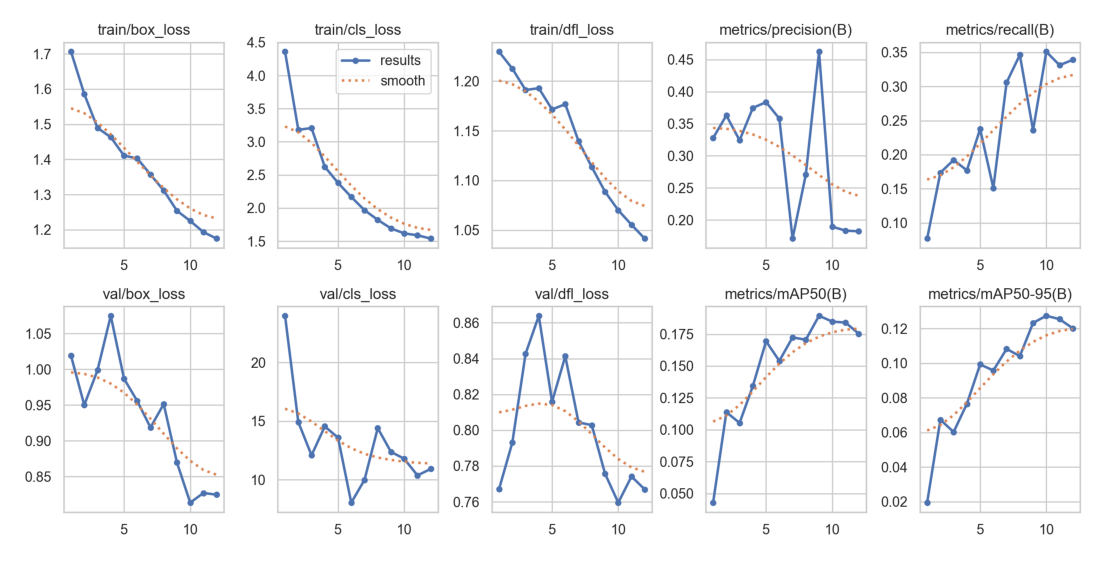

True

In [26]:
check_img = cv2.imread(f"{results.save_dir}/results.png")
check_img = cv2.cvtColor(check_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 21))
plt.imshow(check_img)
plt.axis("off")
plt.show()

save_path = "artifacts/yolo_training.jpg"
cv2.imwrite(str(save_path), cv2.cvtColor(check_img, cv2.COLOR_RGB2BGR))

Выведем данные по последней эпохе

In [27]:
csv_yolo_train = f"{results.save_dir}/results.csv"
df_yolo_train = pd.read_csv(csv_yolo_train)
print('Результаты обучения по последней эпохе')
df_yolo_train.tail(1)

Результаты обучения по последней эпохе


epoch        train/box_loss        train/cls_loss  \
11                    12                1.1749                1.5383   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
11                1.0414               0.18219                0.3391   

        metrics/mAP50(B)   metrics/mAP50-95(B)          val/box_loss  \
11               0.17533               0.12016               0.82444   

            val/cls_loss          val/dfl_loss                lr/pg0  \
11                10.921               0.76691              0.000036   

                  lr/pg1                lr/pg2  
11              0.000036              0.000036

Видно, что модель стабильно обучается на первых 50 эпохах: все её loss-функции стабильно падают, а все ключевые метрики (Precision, Recall, mAP) растут. (ну если запустить на 50)

Однако Объекты находятся, но совсем не идеально

## **3.2. Дообучение модели семейства FSOC**

Можно использовать подготовленный скрипт для обучения train.py. Но чтобы посмотреть, что у нас передалось в runner сделаем последовательно в ячейках Jupiter 

In [28]:
## Путь к  конфигу FCOS
config_path = './configs/fcos/fcos_minecraft02.py'
cfg = Config.fromfile(config_path)

Выполним на 12 эпохах как в задании 

In [29]:
cfg.train_cfg['max_epochs'] = max_epochs

Используем здесь ту же логику как и при обучении YOLO, если файл весов есть пропускаем шаг обучения (так как мы уже обучали в прошлые разы, и каждый раз тестировать код и ждать пока что то обучится не рацинально). Я не буду сохранять каждую эпоху, потому что файл весит 216 мбт, нет смысла тратить место на диске и так все вместе весит 2гбт

In [30]:
if os.path.exists("./checkpoints/last_best_fcos0.pth"):
    print('есть файл весов для модели, используем его: "checkpoints/last_best_fcos.pth" ')
    checkpoint = './checkpoints/last_best_fcos.pth'
    cfg.load_from = checkpoint
else:
    print('обучаем заново с default values по весам')
    checkpoint = 'checkpoints/fcos_r50_caffe.pth'
    cfg.load_from = checkpoint    
runner = Runner.from_cfg(cfg)
print("=== CHECK MODEL INFO ===")
print("Model num_classes:", runner.model.bbox_head.num_classes)
print("\n=== CHECK DATASET INFO ===")
train_loader = runner.build_dataloader(cfg.train_dataloader)
print("Dataset classes:", train_loader.dataset.metainfo['classes'])
# start training 
runner.train()
# path to new weights file
checkpoint_fcos = './artifacts/fcos/epoch_'+ f'{cfg.train_cfg.max_epochs}'+'.pth'

обучаем заново с default values по весам
01/09 17:05:10 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1608637542
    GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
    CUDA_HOME: None
    MSVC: n/a, reason: fileno
    PyTorch: 2.1.0+cu118
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm

Построим графики метрик из `artifacts/fcos/log.json` было наверное лучше использовать runner.message_hub - но его нужно настроить и "тащить" правильно, а если использовать re можно и из файла

loss — общий train-loss. Удобен, чтобы видеть, падает ли обучение и нет ли развала.

loss_cls — ошибка классификации. Если застрял/растёт — модель путает классы, проблемы с разметкой/дисбалансом/learning rate.

loss_bbox — ошибка по координатам боксов. Если высокий — плохая локализация (разметка, scale, аугментации, lr).

loss_centerness — специфично для FCOS: насколько модель уверена, что точка в центре объекта.

In [31]:
path2metric = Path(runner.work_dir) / runner.timestamp / (runner.timestamp + '.log')

losses, losses_cls, losses_bbox,  losses_centerness  = [], [], [], []

with open(path2metric, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        if "Epoch(train)" in line and " loss:" in line and " lr:" in line:
            loss = re.search(r" loss:\s*([0-9.]+)", line)
            loss_cls   = re.search(r" loss_cls:\s*([0-9eE.+-]+)", line)
            loss_bbox   = re.search(r" loss_bbox:\s*([0-9eE.+-]+)", line)
            loss_centerness   = re.search(r" loss_centerness:\s*([0-9eE.+-]+)", line)
            if loss:
                losses.append(float(loss.group(1)))
                losses_cls.append(float(loss_cls.group(1)))
                losses_bbox.append(float(loss_bbox.group(1))) 
                losses_centerness.append(float(loss_centerness.group(1)))

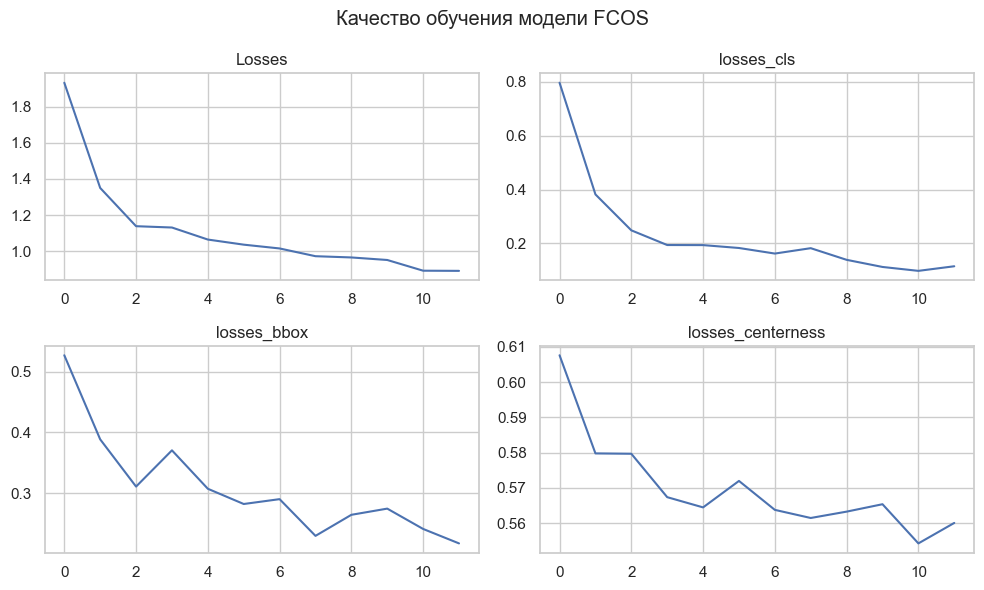

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Качество обучения модели FCOS")
axs[0, 0].plot(losses[::11]);
axs[0, 0].set_title("Losses")
axs[0, 1].plot(losses_cls[::11]);
axs[0, 1].set_title("losses_cls")
axs[1, 0].plot(losses_bbox[::11]);
axs[1, 0].set_title("losses_bbox")
axs[1, 1].plot(losses_centerness[::11]);
axs[1, 1].set_title("losses_centerness")

plt.tight_layout()

out_path = "artifacts/fcos_training.jpg"
fig.savefig(out_path, dpi=200, bbox_inches="tight")  


plt.show()

## Этап 3 — Обучение моделей
### FCOS
- [x] Реализован код дообучения FCOS (в ноутбуке вызываются функции из `.py`)
- [x] Запущено обучение FCOS на train
- [x] Сохранены логи/веса/контрольные результаты в `artifacts/fcos/`
- [x] Построены графики метрик из `artifacts/fcos/log.json`

### YOLO
- [x] Запущено обучение YOLO на том же датасете
- [x] (Опционально) Попробованы другие аугментации / больше эпох
- [x] Сохранены логи/веса в `artifacts/yolo/`
- [x] Построены графики метрик из `artifacts/yolo/results.csv`

# **4. Инференс моделей**

In [33]:
# Путь к тестовым изображениям ===
test_dir = folder + 'test'

all_imgs = [
    os.path.join(test_dir, f)
    for f in os.listdir(test_dir)
    if f.lower().endswith((".jpg", ".png", ".jpeg"))
]

all_imgs_names = [os.path.basename(p) for p in all_imgs]
# выберем изображения для вывода 
sample_imgs = random.sample(all_imgs, 5)
sample_file_names = [os.path.basename(p) for p in sample_imgs]

## **4.1. Тестирование модели семейства FSOC**

Делаем интерфересн на test данных

как раньше писал, пусть будут лучшие веса по 72 эпохам. Кстати говоря, YOLO обучается дольше, если FCOS плюс минус хватило 12-15 эпох, но YOLO прям получше на 72

In [34]:
#checkpoint_fcos текущий, 
checkpoint_fcos_best="checkpoints/last_best_fcos.pth"
# Initialize the DetInferencer
inferencer_fcos = DetInferencer(model=config_path, weights=checkpoint_fcos, show_progress=False)
# Perform inference
interference_fcos_results = inferencer_fcos(all_imgs, out_dir='./artifacts/inference/fcos', no_save_pred=False, return_datasamples=True);

Loads checkpoint by local backend from path: ./artifacts/fcos/epoch_12.pth
01/09 17:23:38 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


## **4.2. Тестирование модели семейства YOLO**

In [35]:
## текущий 
#model_yolo = YOLO(f"{results.save_dir}/weights/best.pt")   
model_yolo = YOLO("checkpoints/last_best_yolo.pt")        
results_yolo = model_yolo.predict(
    source=all_imgs,
    conf=0.25,
    imgsz=640,
    save=True,                                 # сохраняет картинки с боксами
    project='./artifacts/inference/yolo',
    name="yolo",
    exist_ok=True
);


0: 640x640 1 sheep, 1: 640x640 (no detections), 2: 640x640 1 cow, 3: 640x640 1 cow, 4: 640x640 1 goat, 5: 640x640 1 chicken, 1 goat, 6: 640x640 (no detections), 7: 640x640 (no detections), 8: 640x640 1 sheep, 9: 640x640 1 sheep, 10: 640x640 1 chicken, 11: 640x640 (no detections), 12: 640x640 1 sheep, 13: 640x640 1 sheep, 14: 640x640 1 chicken, 15: 640x640 (no detections), 16: 640x640 (no detections), 17: 640x640 2 pigs, 18: 640x640 1 chicken, 19: 640x640 (no detections), 20: 640x640 2 cows, 21: 640x640 1 pig, 22: 640x640 (no detections), 23: 640x640 (no detections), 24: 640x640 1 sheep, 25: 640x640 (no detections), 26: 640x640 2 sheeps, 27: 640x640 (no detections), 28: 640x640 1 cow, 29: 640x640 1 sheep, 30: 640x640 (no detections), 31: 640x640 1 chicken, 32: 640x640 1 sheep, 33: 640x640 1 chicken, 34: 640x640 2 cows, 35: 640x640 (no detections), 36: 640x640 1 sheep, 37: 640x640 (no detections), 38: 640x640 2 pigs, 39: 640x640 2 chickens, 40: 640x640 2 chickens, 41: 640x640 1 chicken,

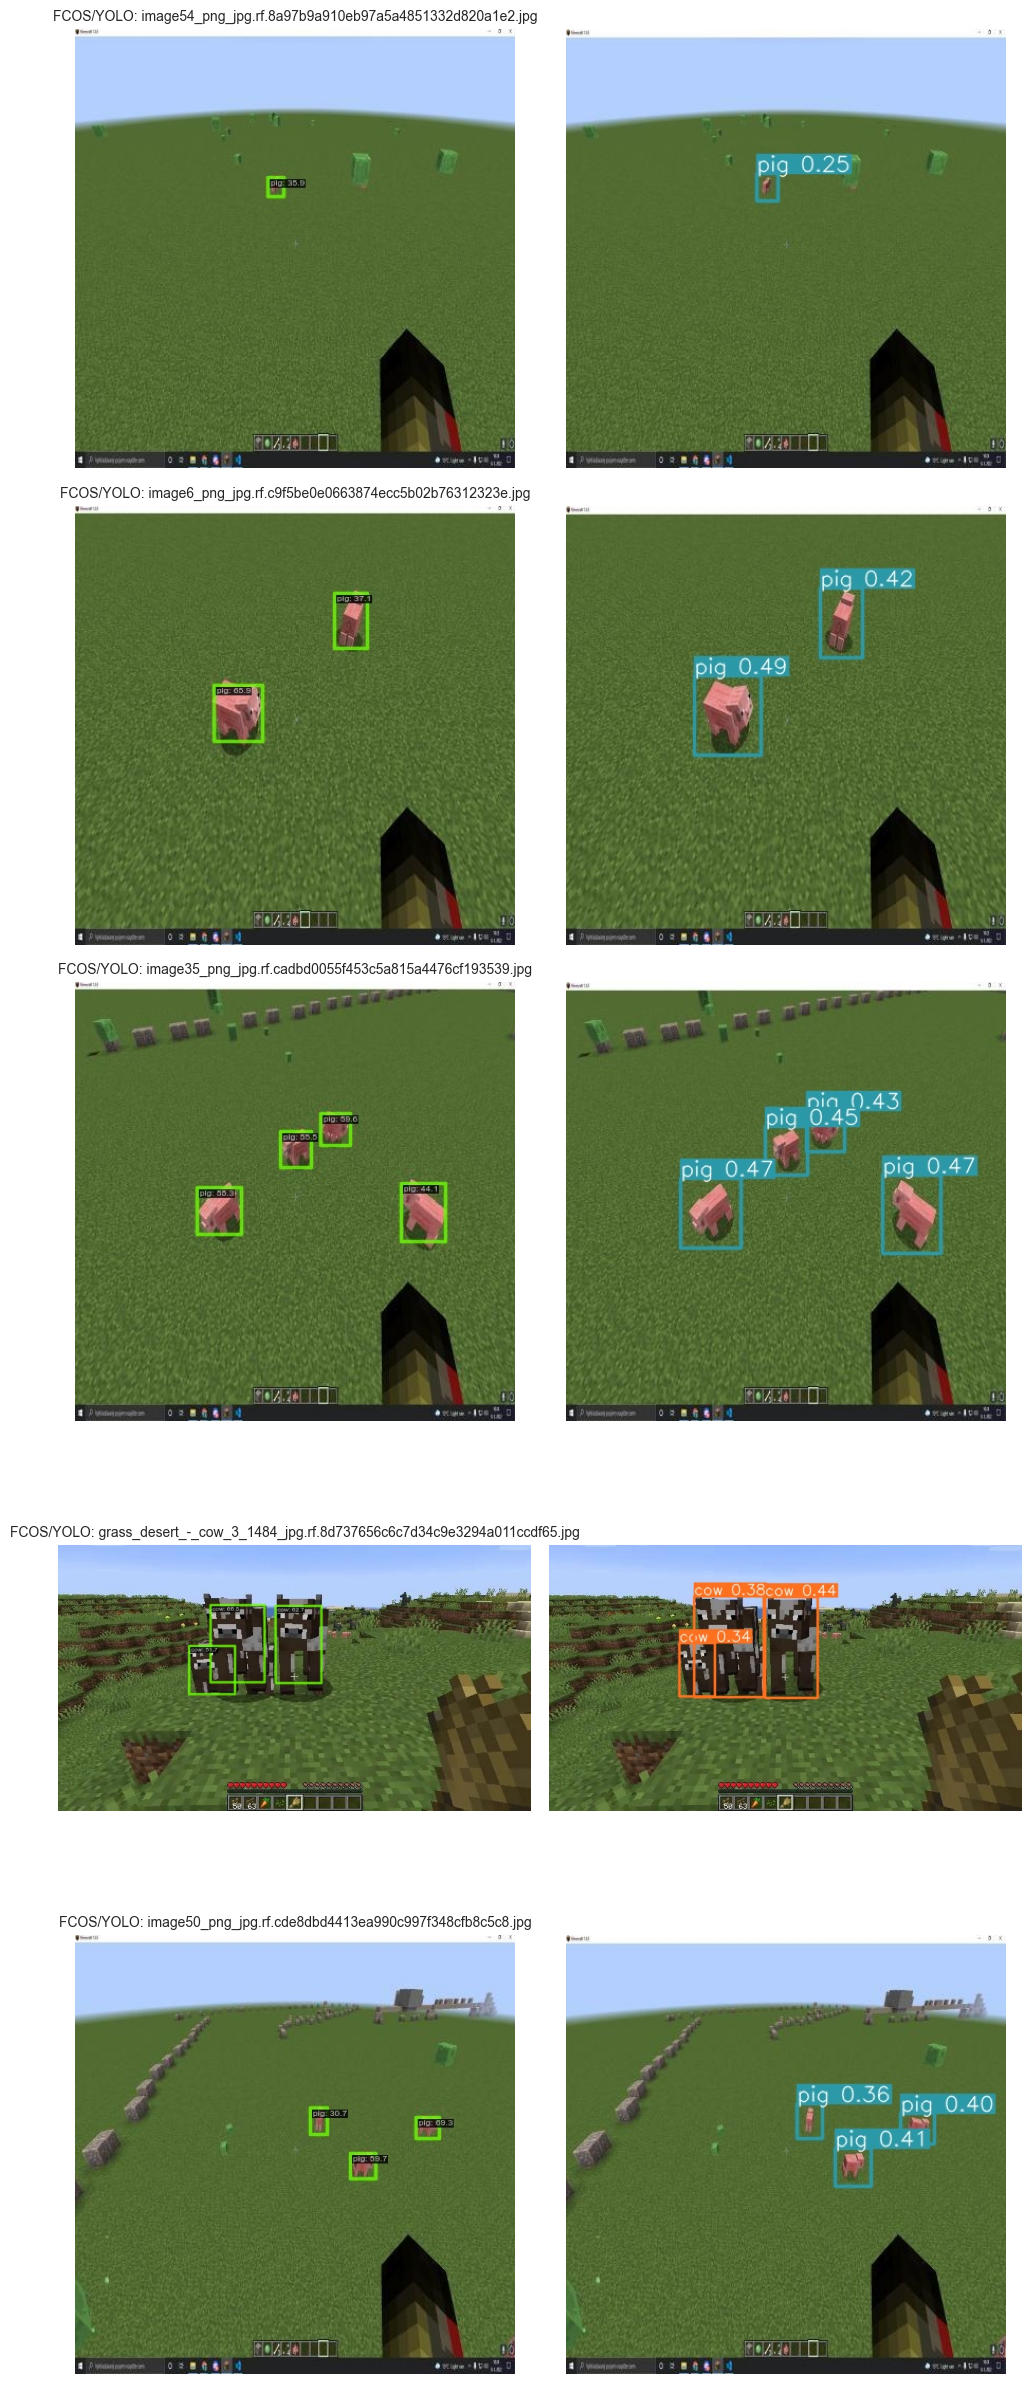

In [36]:
# Показываем все результаты
fig, axs = plt.subplots(5, 2, figsize=(10, 24))
for  i, rf in enumerate(sample_file_names):
    img_fcos = Image.open('./artifacts/inference/fcos/vis/'+rf)
    img_yolo = Image.open('./artifacts/inference/yolo/yolo/'+rf)
  
    axs[i, 0].imshow(img_fcos)
    axs[i, 0].set_title(f"FCOS/YOLO: {rf}", fontsize=10)
    axs[i, 0].axis("off")
    axs[i, 1].imshow(img_yolo)
    axs[i, 1].axis("off")

plt.tight_layout()

out_path = "artifacts/inference/training_comparetion_pic.jpg"
fig.savefig(out_path, dpi=200, bbox_inches="tight")  

plt.show()

## **4.3. Сравнение стандартных метрик**

Сформируем таблицы для сравнения метрик использованных моделей. Сделаем одну таблицу по mAPs и по таблице для Precision, Recall и F1 - по-тому что они для каждого класса свои.

In [37]:
col_names = ['FPS', 'mAP_50', 'mAP50-95']
idx_names = ['YOLO', 'FCOS_MMDet']
metric_comparison     = pd.DataFrame('-', index=idx_names, columns=col_names)
precision_comparison = pd.DataFrame('-', index=idx_names, columns=class_names)
recall_comparison    = pd.DataFrame('-', index=idx_names, columns=class_names)
f1_comparison        = pd.DataFrame('-', index=idx_names, columns=class_names)
df_names = ['metric_comparison', 'precision_comparison', 'recall_comparison', 'f1_comparison']

Определим скорость моделей детекции

In [38]:
models = {
    "YOLO": model_yolo,
    "FCOS_MMDet": inferencer_fcos}
fps = measure_fps(
    models,
    image_input=test_img,
    num_runs=100,
    warmup=20,
);



==================== Результаты измерения End-to-End FPS ====================
YOLO           : 80.76 FPS
FCOS_MMDet     : 30.57 FPS


In [39]:
metric_comparison['FPS']['YOLO'] = round(fps['YOLO'],1)
metric_comparison['FPS']['FCOS_MMDet'] = round(fps['FCOS_MMDet'],1)

Немного FCOS_MMDet по-быстрее. Но довольно часто получается по разному.

Вытащим метрики для YOLO модели 

In [40]:
metrics_yolo = model_yolo.val(
    data='dataset\minecraft\data_coco.yaml',
    split="test",        
    conf=0.25,
    imgsz=640,                             
    iou=0.5,
    verbose=False,
    project='./artifacts/inference/yolo',
    name="metrics",
)

Ultralytics YOLOv8.0.196  Python-3.10.19 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
val: Scanning G:\_Work\python_lab\practicum\advanced_part_Img_\Ch01_Objects_detection_\mmdetection\dataset\minecraft\test.cache... 155 images, 155 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]
                   all        310        351      0.399      0.517        0.4      0.282
Speed: 0.4ms preprocess, 3.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to artifacts\inference\yolo\metrics2


Заполняем таблицы данными для YOLO модели

In [41]:
names_present = [class_names[i] for i in metrics_yolo.ap_class_index]
metric_comparison['mAP_50']['YOLO'] = round(metrics_yolo.box.map50,3)
metric_comparison['mAP50-95']['YOLO'] = round(metrics_yolo.box.map,3)
precision_comparison.loc["YOLO", names_present] = metrics_yolo.box.p
recall_comparison   .loc["YOLO", names_present] = metrics_yolo.box.r
f1_comparison       .loc["YOLO", names_present] = 2*metrics_yolo.box.p*metrics_yolo.box.r/(metrics_yolo.box.p + metrics_yolo.box.r + 1e-9)

В FCOS нет таких метрик как F1, recall и precision. Поэтому получим данные самостоятельно с использованием пользовательской функции. Для этого извлечем правильные рамки GT из JSON файла, а предсказанные из interference полученного ранее.

Возьмем рамки из ISON файла, а предсказания с интерференса FCOS и для conf = 0.25 посчитаем Precision, Recall, F1-score

In [42]:
gts_by_name  = get_gt_info (class_names)
predict_by_name = get_predict_info(interference_fcos_results, score_thr=0.0001)
keys = sorted(gts_by_name.keys())
ground_truths = [gts_by_name[k] for k in keys]
predictions   = [predict_by_name[k] for k in keys]

In [43]:
metrics_fcos = calculate_prf1_all_classes(
    predictions=predictions,
    ground_truths=ground_truths,
    num_classes=len(class_names),
    score_thr=0.25,
    iou_threshold=0.5
)

In [44]:
iou_thresholds = [0.50 + 0.05 * k for k in range(10)]  
map_by_iou = []
for thr in tqdm(iou_thresholds):
    m = calculate_map(predictions, ground_truths, num_classes, iou_threshold=thr)
    map_by_iou.append(m)

100%|██████████| 10/10 [01:07<00:00,  6.77s/it]


Заполняем таблицы данными для FCOS модели

In [45]:
metric_comparison['mAP_50']['FCOS_MMDet'] = round(map_by_iou[0],3)
metric_comparison['mAP50-95']['FCOS_MMDet'] = round(sum(map_by_iou) / len(map_by_iou),3)
precision_comparison.loc["FCOS_MMDet"] = metrics_fcos["precision_per_class"]
recall_comparison   .loc["FCOS_MMDet"] = metrics_fcos["recall_per_class"]
f1_comparison       .loc["FCOS_MMDet"] = metrics_fcos["f1_per_class"]

In [46]:
for i, tab in enumerate([metric_comparison, precision_comparison, recall_comparison, f1_comparison]):
    print(df_names[i], ':')
    display(tab)


metric_comparison :


FPS mAP_50 mAP50-95
YOLO        80.8    0.4    0.282
FCOS_MMDet  30.6  0.492    0.249

precision_comparison :


bee   chicken       cow  creeper enderman  fox frog ghast goat  \
YOLO          -  0.269231       0.4  0.46875      0.0    -    -     -    -   
FCOS_MMDet  0.0     0.625  0.826087      1.0      0.0  0.0  0.0   0.0  0.0   

           llama       pig sheep skeleton spider turtle wolf zombie  
YOLO           -  0.454106   0.5      0.5    0.5      -    -    0.5  
FCOS_MMDet   0.0  0.792929   1.0      1.0    1.0    0.0  0.0    0.0

recall_comparison :


bee   chicken       cow   creeper enderman  fox frog ghast goat  \
YOLO          -  0.538462  0.909091  0.882353      0.0    -    -     -    -   
FCOS_MMDet  0.0  0.384615  0.863636  0.823529      0.0  0.0  0.0   0.0  0.0   

           llama       pig     sheep skeleton    spider turtle wolf    zombie  
YOLO           -  0.817391  0.245283      0.5  0.428571      -    -  0.333333  
FCOS_MMDet   0.0  0.682609  0.075472      0.5  0.285714    0.0  0.0       0.0

f1_comparison :


bee   chicken       cow   creeper enderman  fox frog ghast goat  \
YOLO          -  0.358974  0.555556  0.612245      0.0    -    -     -    -   
FCOS_MMDet  0.0   0.47619  0.844444  0.903225      0.0  0.0  0.0   0.0  0.0   

           llama       pig     sheep  skeleton    spider turtle wolf zombie  
YOLO           -  0.583851  0.329114       0.5  0.461538      -    -    0.4  
FCOS_MMDet   0.0  0.733644  0.140351  0.666666  0.444444    0.0  0.0    0.0

Сравним со метриками на тесте от FCOS - mAP такие же  

In [47]:
# Compute metrics on test
metrics = runner.test();
print('mAP50',metrics['coco/bbox_mAP_50'])
print('mAP50-95',metrics['coco/bbox_mAP'])

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
01/09 17:25:59 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.10s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.264
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.522
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.221
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.285
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Av

Запишем все в одну таблицу в папку artifacts/metrics/

In [48]:
all_in_one = pd.concat(
    {
        "metric": metric_comparison,
        "precision": precision_comparison,
        "recall": recall_comparison,
        "f1": f1_comparison,
    },
    axis=1
)
all_in_one.to_csv("artifacts/metrics/metrics_comparison.csv", index=True)
all_in_one

metric                 precision                               \
              FPS mAP_50 mAP50-95       bee   chicken       cow  creeper   
YOLO         80.8    0.4    0.282         -  0.269231       0.4  0.46875   
FCOS_MMDet   30.6  0.492    0.249       0.0     0.625  0.826087      1.0   

                               ...    f1                                 \
           enderman  fox frog  ... ghast goat llama       pig     sheep   
YOLO            0.0    -    -  ...     -    -     -  0.583851  0.329114   
FCOS_MMDet      0.0  0.0  0.0  ...   0.0  0.0   0.0  0.733644  0.140351   

                                                   
            skeleton    spider turtle wolf zombie  
YOLO             0.5  0.461538      -    -    0.4  
FCOS_MMDet  0.666666  0.444444    0.0  0.0    0.0  

[2 rows x 54 columns]

## **4.4. Обработка видео файла**

In [49]:
model_type = 'YOLO'
input_video_path = "dataset/minecraft/video.mp4"
output_video_path = 'artifacts/videos/yolo_inference.mp4'
process_video(model_type ,model_yolo, input_video_path, output_video_path, confidence_threshold=0.25, imgsz=640)

Анализ игрового процесса: 100%|██████████| 756/756 [00:47<00:00, 15.96it/s]


Анализ завершен. Результат сохранен в файл: artifacts/videos/yolo_inference.mp4


In [50]:
model_type = 'FCOS'
input_video_path = "dataset/minecraft/video.mp4"
output_video_path = 'artifacts/videos/fcos_inference.mp4'
process_video(model_type ,inferencer_fcos, input_video_path, output_video_path, confidence_threshold=0.25, imgsz=640)

Анализ игрового процесса: 100%|██████████| 756/756 [04:03<00:00,  3.11it/s]


Анализ завершен. Результат сохранен в файл: artifacts/videos/fcos_inference.mp4


В моделей не было шансов...... на видео есть волки овца "с кормы" и много свиней - с ними проблем нет. Остальное без шансов практически. Но надо отметить, что часть волков модели "цепляют". А YOLO модель, в конце видео, в овце нашла овцу !

## Этап 4 — Инференс моделей (изображения + видео)
### Тестовые изображения
- [x] FCOS: прогнать на test-изображениях
- [x] YOLO: прогнать на test-изображениях
- [x] Сохранить результаты:
  - [x] `artifacts/inference/fcos/`
  - [x] `artifacts/inference/yolo/`
- [x] Показать в ноутбуке по 5 изображений на инференсе для FCOS и YOLO

### Сравнение стандартных метрик
- [x] Посчитать на тесте для FCOS и YOLO:
  - [x] mAP
  - [x] mAP_50
  - [x] Precision
  - [x] Recall
  - [x] F1-score
  - [x] FPS
- [x] Вывести сравнение в таблице в ноутбуке
- [x] Сохранить таблицу: `artifacts/metrics/metrics_comparison.csv`

### Видео
- [x] Реализовать инференс видео `datasets/minecraft/video.mp4` для FCOS
- [x] Сохранить: `artifacts/videos/fcos_inference.mp4`
- [x] Реализовать инференс видео `datasets/minecraft/video.mp4` для YOLO
- [x] Сохранить: `artifacts/videos/yolo_inference.mp4`

# **5. Анализ и выводы**

In [52]:
generate_project_report (
    dataset_storage  = "dataset/minecraft",                     # исходный датасет
    config_path = "configs/fcos/fcos_minecraft.py",             # конфиг файл
    artifacts_path = "artifacts",                               # папка с результатами
    out_pdf="artifacts/",                                       # папка для записи отчета
    max_examples=4,
    )

pdf file saved in : artifacts/Minecraft_world_prediction.pdf


## Результаты и выводы

### Итоговые метрики (test set)

| Модель | FPS | mAP@50 | mAP@50-95 | Macro Precision | Macro Recall | Macro F1 |
|---|---:|---:|---:|---:|---:|---:|
| YOLO | 31.3 | 0.400 | 0.282 | 0.399 | 0.517 | 0.422 |
| FCOS (MMDet) | 21.6 | 0.299 | 0.186 | 0.150 | 0.171 | 0.146 |

Примечания:
- Обучение запускалось не “с нуля”: модели были предварительно дообучены (около 72 эпох), а затем выполнялся короткий fine-tuning в рамках проекта.
- Символ `-` в поклассовых Precision/Recall/F1 означает, что метрика не определена (например, на тесте нет объектов данного класса и/или модель не сделала ни одного предсказания этого класса при выбранном пороге).

### Ключевые выводы
- **YOLO** — лучший вариант для real-time: выше скорость (примерно в **1.45 раза быстрее** по FPS) и выше качество по **mAP@50** и **mAP@50-95**.
- **FCOS** сходится по loss стабильно, но по итоговым метрикам качества и скорости уступает YOLO на данном датасете. При этом для **YOLO** нужно больше эпох - обучение более медленное
- На **видео-инференсе** задача заметно сложнее из-за движения камеры, перекрытий (occlusions) и мелких объектов: модели лучше справляются с частыми и “простыми” случаями (например, свиньи), а редкие классы и сложные ракурсы остаются проблемными. Вообще на видео классовое разноообразие невелики. Только овцы как всегда свиньи и волки(которые вообще практически не представлены в тренеровочных данных). Модели учились на свиньях и распознают свиней - все честно ). Конечно не хватает разнообразия по данным.
- Есть вопросы к разметке, как минимум теста. Есть картинки, где размечена неочевидная овца, при это очевидная никак не размечена. И модели в итоге именно "очевидную" и "неразмеченную" выхватывают и это как бы правильно и как бы нет - потому, что метрика падает.
- Что можно улучшить: увеличить разнообразие данных (особенно для редких классов), подобрать confidence/IoU thresholds, добавить аугментации под движение и масштаб.

P/S
- Для меня это **не 12 часов**,  которые закладывались в задании на проект. Не знаю как все остальные с этим справляются, но я прям не уверен, что я смогу успеть сделать следующий проект в таком режиме;
- тот вариант проекта, который я сейчас сдаю, я бы охарактеризовал как "каркас", но сил его доводить то чего-то адекватного у меня уже нет.

## Этап 7 — Анализ и выводы
- [x] Подготовить `artifacts/report.pdf`, включить:
  - [x] выводы по качеству (метрики)
  - [x] выводы по скорости (FPS/время инференса)
  - [x] примеры детекций (картинки)
  - [x] графики для сравнения моделей
- [ x] Обновить `README.md` (что сделано, данные, как запускать, итоговые результаты)

## Финальная самопроверка перед сдачей
- [x] Код запуска обучения + вспомогательные функции вынесены в `.py`
- [x] Ноутбук разбит на смысловые блоки и выполняется сверху вниз без ошибок
- [x] Все нужные артефакты сохранены в `artifacts/`
- [x] В репозиторий НЕ загружены тяжелые данные (если не требуется), но структура путей сохранена